In [195]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
 

In [196]:
# description of the feature:
# Traffic Volume through the Tollgates
# time           datatime        the time when a vehicle passes the tollgate
# tollgate_id    string          ID of the tollgate
# direction      string           0:entry, 1:exit
# vehicle_model  int             this number ranges from 0 to 7, which indicates the capacity of the vehicle(bigger the higher)
# has_etc        string          does the vehicle use ETC (Electronic Toll Collection) device? 0: No, 1: Yes
# vehicle_type   string          vehicle type: 0-passenger vehicle, 1-cargo vehicle
volume_df = pd.read_csv("volume(table 6)_training.csv")
# volume_df2 = pd.read_csv("../testing_phase1/volume(table 6)_test1.csv")
# volume_df = volume_df.append(volume_df2)
volume_df.head()

,time,tollgate_id,direction,vehicle_model,has_etc,vehicle_type
0,2016-09-19 23:09:25,2,0,1,0,NaN
1,2016-09-19 23:11:53,2,0,1,0,NaN
2,2016-09-19 23:13:54,2,0,1,0,NaN
3,2016-09-19 23:17:48,1,0,1,1,NaN
4,2016-09-19 23:16:07,2,0,1,0,NaN


In [197]:
# 未处理数据的统计特征
print volume_df.info()
volume_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543699 entries, 0 to 543698
Data columns (total 6 columns):
time             543699 non-null object
tollgate_id      543699 non-null int64
direction        543699 non-null int64
vehicle_model    543699 non-null int64
has_etc          543699 non-null int64
vehicle_type     212710 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 24.9+ MB
None


,tollgate_id,direction,vehicle_model,has_etc,vehicle_type
count,543699.000000,543699.000000,543699.000000,543699.000000,212710.00000
mean,2.086138,0.391227,1.089689,0.221420,0.22597
std,0.925612,0.488026,0.838314,0.415203,0.41822
min,1.000000,0.000000,0.000000,0.000000,0.00000
25%,1.000000,0.000000,1.000000,0.000000,0.00000
50%,2.000000,0.000000,1.000000,0.000000,0.00000
75%,3.000000,1.000000,1.000000,0.000000,0.00000
max,3.000000,1.000000,7.000000,1.000000,1.00000


In [176]:
# 发现很多数字特征都是标签类，对所有标签类做替换，首先观察tollgate一共有多少种编号
volume_df['tollgate_id'].unique()

array([2, 1, 3], dtype=int64)

In [178]:
# 替换所有有标签含义的数字
volume_df['tollgate_id'] = volume_df['tollgate_id'].replace({1:"1S", 2:"2S", 3:"3S"})
volume_df['direction'] = volume_df['direction'].replace({0:"entry", 1:"exit"})
volume_df['has_etc'] = volume_df['has_etc'].replace({0:"No", 1:"Yes"})
volume_df['vehicle_type'] = volume_df['vehicle_type'].replace({0:"passenger", 1:"carge"})
volume_df['time'] = volume_df['time'].apply(lambda x: pd.Timestamp(x))
volume_df.head()

,time,tollgate_id,direction,vehicle_model,has_etc,vehicle_type
0,2016-09-19 23:09:25,2S,entry,1,No,NaN
1,2016-09-19 23:11:53,2S,entry,1,No,NaN
2,2016-09-19 23:13:54,2S,entry,1,No,NaN
3,2016-09-19 23:17:48,1S,entry,1,Yes,NaN
4,2016-09-19 23:16:07,2S,entry,1,No,NaN


In [87]:
# vehicle_type的空值太多，思考如何填空值
# 从统计量里可以大致估计
# 承载量大于等于5的为货运汽车，所有承载量为0的车都类型不明
# 承载量：1-默认客车，2-默认货车，3-默认货车，4-默认客车
print "that value of vehicle_model is when vehicle_type is nan"
print volume_df.loc[pd.isnull(volume_df['vehicle_type']), :].groupby(['vehicle_model']).count()
print volume_df.dropna().groupby(['vehicle_type', 'vehicle_model']).count()

that value of vehicle_model is when vehicle_type is nan
                 time  tollgate_id  direction  has_etc  vehicle_type
vehicle_model                                                       
0               77410        77410      77410    77410             0
1              209787       209787     209787   209787             0
2               35705        35705      35705    35705             0
3                2810         2810       2810     2810             0
4                2724         2724       2724     2724             0
5                2398         2398       2398     2398             0
6                   6            6          6        6             0
7                 149          149        149      149             0
                              time  tollgate_id  direction  has_etc
vehicle_type vehicle_model                                         
carge        1               24973        24973      24973    24973
             2               11663        11663   

In [88]:
# 承载量：1-默认客车，2-默认货车，3-默认货车，4-默认客车
# 承载量大于等于5的为货运汽车，所有承载量为0的车都类型不明
volume_df = volume_df.sort_values(by="vehicle_model")
vehicle_model0 = volume_df[volume_df['vehicle_model'] == 0].fillna("No")
vehicle_model1 = volume_df[volume_df['vehicle_model'] == 1].fillna("passenger")
vehicle_model2 = volume_df[volume_df['vehicle_model'] == 2].fillna("carge")
vehicle_model3 = volume_df[volume_df['vehicle_model'] == 3].fillna("carge")
vehicle_model4 = volume_df[volume_df['vehicle_model'] == 4].fillna("passenger")
vehicle_model5 = volume_df[volume_df['vehicle_model'] >= 5].fillna("carge")
volume_df = pd.concat([vehicle_model0, vehicle_model1, vehicle_model2, vehicle_model3, vehicle_model4, vehicle_model5])
volume_df[volume_df.isnull()].count()

time             0
tollgate_id      0
direction        0
vehicle_model    0
has_etc          0
vehicle_type     0
dtype: int64

In [89]:
print volume_df.info()
volume_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 543699 entries, 146094 to 361835
Data columns (total 6 columns):
time             543699 non-null datetime64[ns]
tollgate_id      543699 non-null object
direction        543699 non-null object
vehicle_model    543699 non-null int64
has_etc          543699 non-null object
vehicle_type     543699 non-null object
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 29.0+ MB
None


,time,tollgate_id,direction,vehicle_model,has_etc,vehicle_type
146094,2016-10-01 17:06:59,1S,entry,0,No,No
190268,2016-10-05 08:40:01,1S,entry,0,No,No
190269,2016-10-05 08:40:04,1S,entry,0,No,No
190270,2016-10-05 08:40:10,1S,entry,0,No,No
190272,2016-10-05 08:41:00,1S,entry,0,No,No


In [90]:
# 观察日期范围，发现日期跨度比想象中要长，重新阅读题目，之前理解题目错了
# 训练集是已知9月19日至10月17日之间所有数据：从0点到24点
# 预测集是10月18日至10月24日的其中两个时段：6点-8点，14点-16点
# 需要预测10月18日至10月24日剩下两个时段：8点-10点，16点-18点
volume_day = pd.DataFrame()
volume_day['day'] = volume_df['time'].apply(lambda x: x.day)
volume_day['month'] = volume_df['time'].apply(lambda x: x.month)
volume_day.groupby(['month', 'day']).count()

Empty DataFrame
Columns: []
Index: [(9, 19), (9, 20), (9, 21), (9, 22), (9, 23), (9, 24), (9, 25), (9, 26), (9, 27), (9, 28), (9, 29), (9, 30), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (10, 16), (10, 17)]

                     volume  hour  min  day  month
time                                              
2016-09-19 00:00:00     2.0     0    0   19      9
2016-09-19 00:20:00     NaN     0   20   19      9
2016-09-19 00:40:00     NaN     0   40   19      9
2016-09-19 01:00:00     1.0     1    0   19      9
2016-09-19 01:20:00     NaN     1   20   19      9


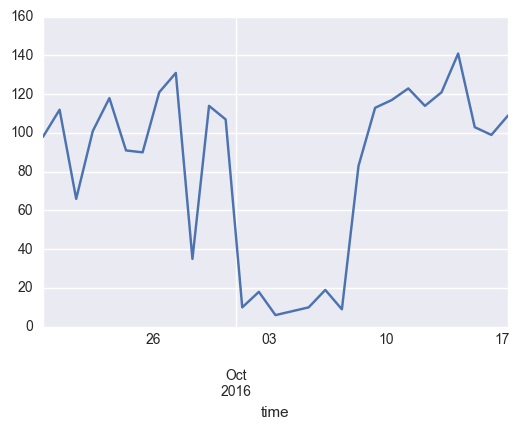

mean of count :  82.3103448276
max count :  141.0
sqrt std :  45.26043956
min count :  6.0


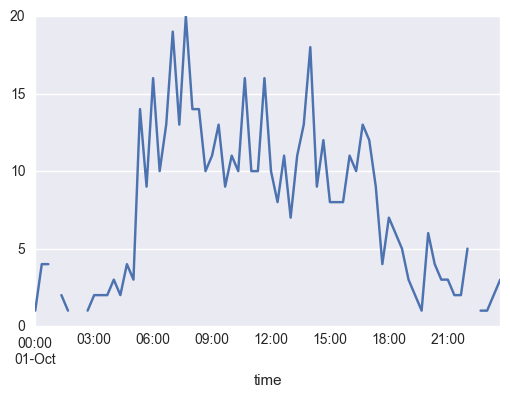

In [188]:
# 观察每一天同一时间段内的车流量
volume_time_period = pd.Series(data = 1, index=volume_df.loc[volume_df['tollgate_id']=="2S", :]['time'])
volume_time_period = volume_time_period.resample("20T").sum()
volume_time_df = pd.DataFrame(index=volume_time_period.index)
volume_time_df['volume'] = volume_time_period
volume_time_df['hour'] = volume_time_period.index.hour
volume_time_df['min'] = volume_time_period.index.minute
volume_time_df['day'] = volume_time_period.index.day
volume_time_df['month'] = volume_time_period.index.month
# 展示进站口1每天6点-6点20分的车流量
print volume_time_df.head()
filter_df = (volume_time_df['hour'] == 8) & (volume_time_df['min'] == 40)
volume_time_df[filter_df]['volume'].plot()
plt.show()
print "mean of count : ", volume_time_df[filter_df]['volume'].mean()
print "max count : ", volume_time_df[filter_df]['volume'].max()
print "sqrt std : ", volume_time_df[filter_df]['volume'].std()
print "min count : ", volume_time_df[filter_df]['volume'].min()
# 把时间段从6点到8点以20分钟为单位一直观察下去，发现，10月1日某些时段存在突变点，而且不存在以周为单位的周期性
# 观察某一天的车流图
filter_df = (volume_time_df['month'] == 10) & (volume_time_df['day'] == 1)
volume_time_df[filter_df]['volume'].plot()
plt.show()

In [189]:
# 拿到20分钟的最大值，可以据此判断一个关口20分钟内的车流上限
print "max in all account : ", volume_time_df['volume'].max()
# 最大流量是286，假设这个是1号关口20分钟的车流上限，输出车流在270以上的时间
volume_time_df[volume_time_df['volume'] >= 250].index

max in all account :  148.0


DatetimeIndex([], dtype='datetime64[ns]', name=u'time', freq='20T')

In [193]:
volume_time_df = volume_time_df.fillna(0)
volume_time_df.head()

,volume,hour,min,day,month
time,,,,,
2016-09-19 00:00:00,2.0,0,0,19,9
2016-09-19 00:20:00,0.0,0,20,19,9
2016-09-19 00:40:00,0.0,0,40,19,9
2016-09-19 01:00:00,1.0,1,0,19,9
2016-09-19 01:20:00,0.0,1,20,19,9


In [194]:
# 创建训练集，总的要求就是以前两个小时数据为训练集，用迭代式预测方法
# 例如8点-10点的数据预测10点20,8点-10点20预测10点40……，每一次预测使用的都是独立的（可能模型一样）的模型
# 现在开始构建训练集
# 第一个训练集特征是所有两个小时（以20分钟为一个单位）的数据，因变量是该两小时之后20分钟的流量
train_df1 = pd.DataFrame()
for i in range(len(volume_time_df) - 6):
    df_temp = volume_time_df.iloc[i:i + 7, 0].T
    df_temp.index = range(7)
    train_df1 = train_df1.append(df_temp)
train1_X = train_df1.iloc[:, :6]
train1_y = train_df1.iloc[:, 6]


In [183]:
# 第二个训练集，特征是所有两个小时又20分钟（以20分钟为一个单位）的数据，因变量是该两个小时之后20分钟的流量
train_df2 = pd.DataFrame()
for i in range(len(volume_time_df) - 7):
    df_temp = volume_time_df.iloc[i:i + 8, 0].T
    df_temp.index = range(8)
    train_df2 = train_df2.append(df_temp)
train2_X = train_df2.iloc[:, :7]
train2_y = train_df2.iloc[:, 7]

In [184]:
# 第三个训练集，特征是所有两个小时又40分钟（以20分钟为一个单位）的数据，因变量是该两个小时之后40分钟的流量
train_df3 = pd.DataFrame()
for i in range(len(volume_time_df) - 8):
    df_temp = volume_time_df.iloc[i:i + 9, 0].T
    df_temp.index = range(9)
    train_df3 = train_df3.append(df_temp)
train3_X = train_df3.iloc[:, :8]
train3_y = train_df3.iloc[:, 8]

In [185]:
# 第4个训练集，特征是所有三个小时（以20分钟为一个单位）的数据，因变量是该三个小时之后20分钟的流量
train_df4 = pd.DataFrame()
for i in range(len(volume_time_df) - 9):
    df_temp = volume_time_df.iloc[i:i + 10, 0].T
    df_temp.index = range(10)
    train_df4 = train_df4.append(df_temp)
train4_X = train_df4.iloc[:, :9]
train4_y = train_df4.iloc[:, 9]

In [186]:
# 第5个训练集，特征是所有三个小时又20分（以20分钟为一个单位）的数据，因变量是该三个小时又20分之后20分钟的流量
train_df5 = pd.DataFrame()
for i in range(len(volume_time_df) - 10):
    df_temp = volume_time_df.iloc[i:i + 11, 0].T
    df_temp.index = range(11)
    train_df5 = train_df5.append(df_temp)
train5_X = train_df5.iloc[:, :10]
train5_y = train_df5.iloc[:, 10]

In [187]:
# 第6个训练集，特征是所有三个小时又40分（以20分钟为一个单位）的数据，因变量是该三个小时又40分之后20分钟的流量
train_df6 = pd.DataFrame()
for i in range(len(volume_time_df) - 11):
    df_temp = volume_time_df.iloc[i:i + 12, 0].T
    df_temp.index = range(12)
    train_df6 = train_df6.append(df_temp)
train6_X = train_df6.iloc[:, :11]
train6_y = train_df6.iloc[:, 11]